In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc)
from google.colab import files
from itertools import cycle

In [3]:
# Task 1: Image Processing
def upload_and_read_image():
    """Upload and read image in Colab"""
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    img = cv2.imread(file_name)
    return img

def resize_image(image, scale_factor=0.5, method='linear'):
    """Resize image using different interpolation methods"""
    new_width = int(image.shape[1] * scale_factor)
    new_height = int(image.shape[0] * scale_factor)

    interpolation_methods = {
        'linear': cv2.INTER_LINEAR,
        'nearest': cv2.INTER_NEAREST,
        'polynomial': cv2.INTER_CUBIC
    }

    method = interpolation_methods.get(method.lower(), cv2.INTER_LINEAR)
    return cv2.resize(image, (new_width, new_height), interpolation=method)

def apply_blur(image, method='gaussian', kernel_size=5):
    """Apply different types of blurring to the image"""
    if method.lower() == 'box':
        return cv2.blur(image, (kernel_size, kernel_size))
    elif method.lower() == 'gaussian':
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    elif method.lower() == 'adaptive':
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, kernel_size, 2
        )
    else:
        raise ValueError("Unsupported blur method")

def display_results(original, processed_images, titles):
    """Display original and processed images side by side"""
    fig = plt.figure(figsize=(15, 5))

    # Display original
    plt.subplot(1, len(processed_images) + 1, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')

    # Display processed images
    for i, (image, title) in enumerate(zip(processed_images, titles), 2):
        plt.subplot(1, len(processed_images) + 1, i)
        if len(image.shape) == 2:  # Grayscale
            plt.imshow(image, cmap='gray')
        else:  # Color
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Task 2: MNIST Classification
def load_and_preprocess_mnist():
    """Load and preprocess MNIST dataset"""
    digits = load_digits()
    X = digits.data
    y = digits.target

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return train_test_split(X, y, test_size=0.2, random_state=42)

def train_and_evaluate_models():
    """Train and evaluate Naive Bayes and Random Forest models"""
    X_train, X_test, y_train, y_test = load_and_preprocess_mnist()

    models = {
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        # ROC curve and AUC
        y_test_bin = label_binarize(y_test, classes=range(10))
        y_score = model.predict_proba(X_test)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(10):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        results[name]['roc'] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

        # K-fold cross validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        results[name]['cv_scores'] = cv_scores

        # Print immediate results
        print(f"Accuracy: {results[name]['accuracy']:.4f}")
        print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return results

def plot_results(results):
    """Plot confusion matrices and ROC curves"""
    for name, metrics in results.items():
        # Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(metrics['confusion_matrix'],
                   annot=True,
                   fmt='d',
                   cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # ROC Curves
        plt.figure(figsize=(10, 8))
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green',
                       'yellow', 'purple', 'pink', 'brown', 'gray'])

        for i, color in zip(range(10), colors):
            plt.plot(metrics['roc']['fpr'][i],
                    metrics['roc']['tpr'][i],
                    color=color,
                    label=f'ROC curve of class {i} (AUC = {metrics["roc"]["auc"][i]:0.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves - {name}')
        plt.legend(loc="lower right")
        plt.show()

Upload an image when prompted:


Saving Picture1.jpg to Picture1 (1).jpg


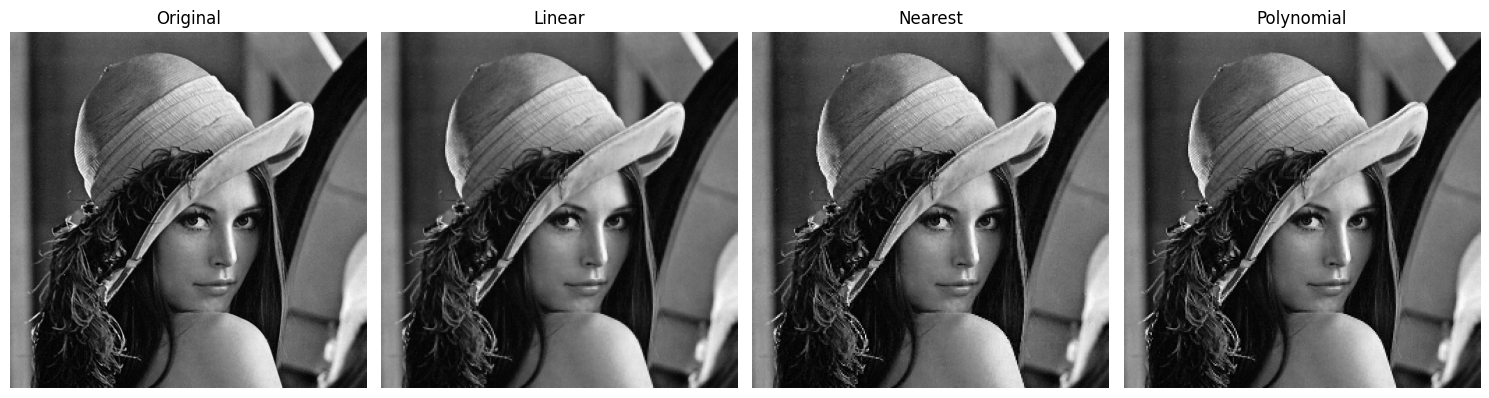

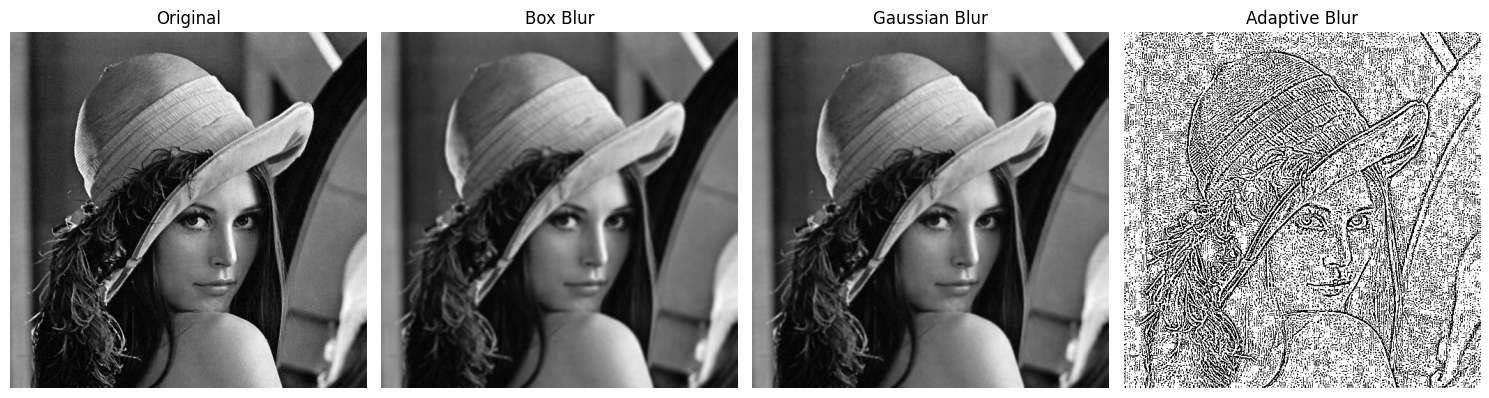

Starting MNIST classification...

Training Naive Bayes...
Accuracy: 0.7667
Cross-validation accuracy: 0.7711 (+/- 0.0675)

Training Random Forest...
Accuracy: 0.9722
Cross-validation accuracy: 0.9736 (+/- 0.0185)


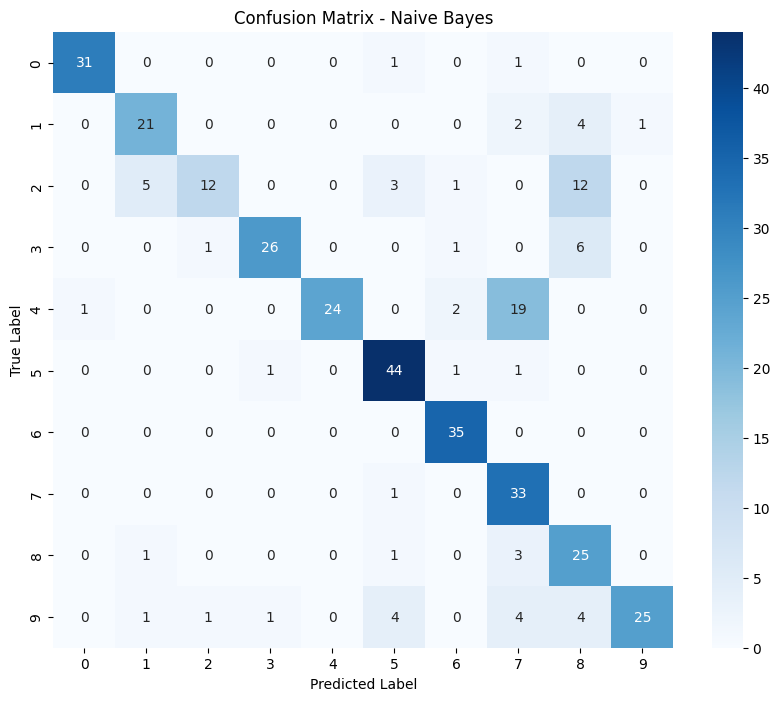

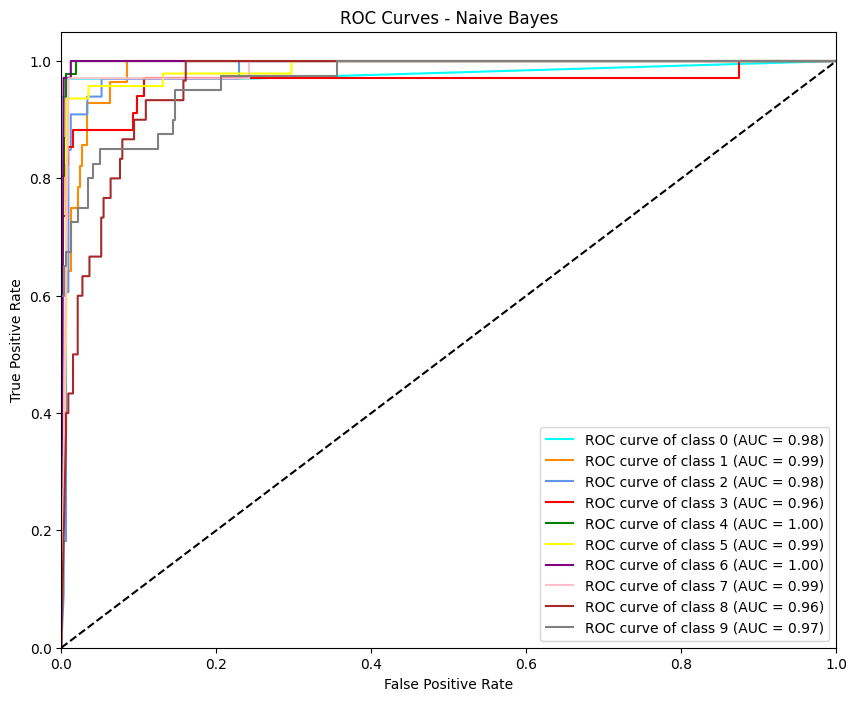

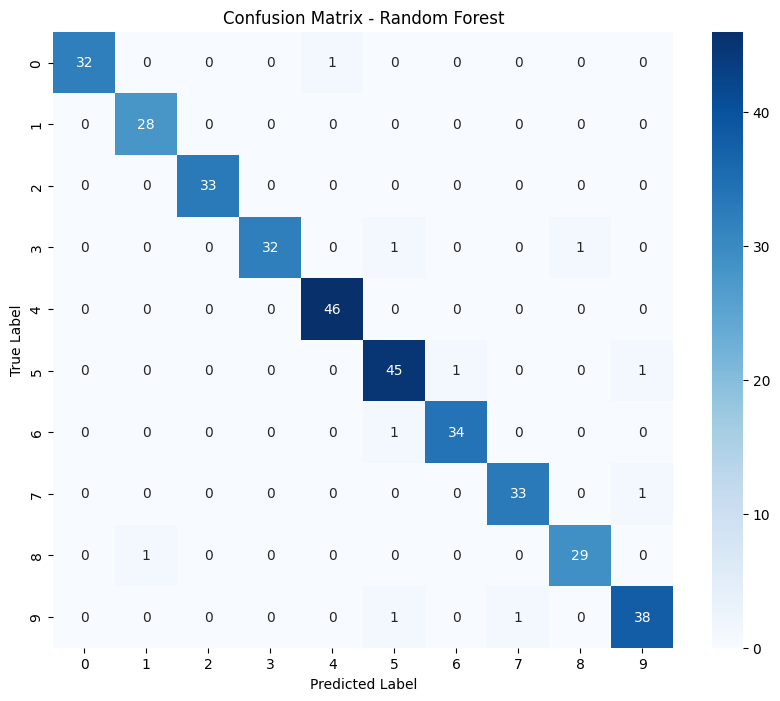

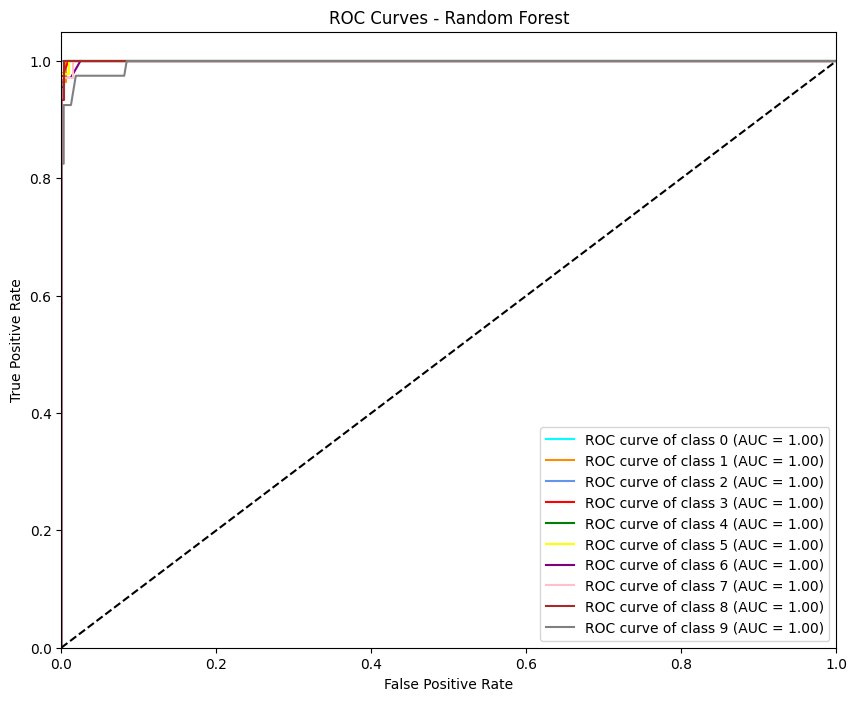

In [4]:
# Task 1
print("Upload an image when prompted:")
img = upload_and_read_image()

# Process and display resized images
resized_linear = resize_image(img, 0.5, 'linear')
resized_nearest = resize_image(img, 0.5, 'nearest')
resized_poly = resize_image(img, 0.5, 'polynomial')

display_results(img,
               [resized_linear, resized_nearest, resized_poly],
               ['Linear', 'Nearest', 'Polynomial'])

# Process and display blurred images
blurred_box = apply_blur(img, 'box')
blurred_gaussian = apply_blur(img, 'gaussian')
blurred_adaptive = apply_blur(img, 'adaptive')

display_results(img,
               [blurred_box, blurred_gaussian, blurred_adaptive],
               ['Box Blur', 'Gaussian Blur', 'Adaptive Blur'])

# Task 2
print("Starting MNIST classification...")
results = train_and_evaluate_models()
plot_results(results)